In [94]:
import tensorflow as tf
import numpy as np
import keras
from keras import layers

In [95]:
image_resize= 256

dataset = tf.keras.preprocessing.image_dataset_from_directory( # load the imaeges 
    "PlantVillage",
    image_size= (image_resize, image_resize),
    shuffle=True,
    batch_size= 32
)

Found 8703 files belonging to 5 classes.


In [96]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [97]:
dataset.class_names

['Tomato_Bacterial_spot',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__YellowLeaf__Curl_Virus',
 'Tomato_healthy']

In [98]:
class_names= dataset.class_names

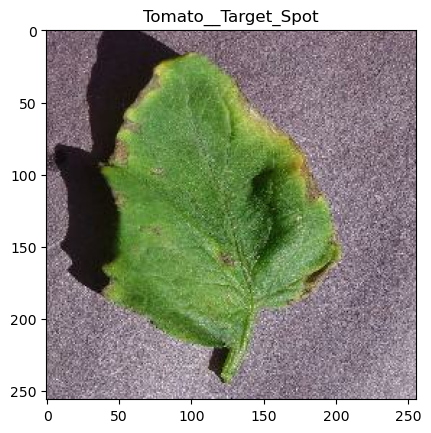

In [99]:
import matplotlib.pyplot as plt

for image, label in dataset.take(1):
    plt.title(class_names[label[1]])
    plt.imshow(image[1].numpy().astype('uint8')) # convert image to a numpy array and plot)

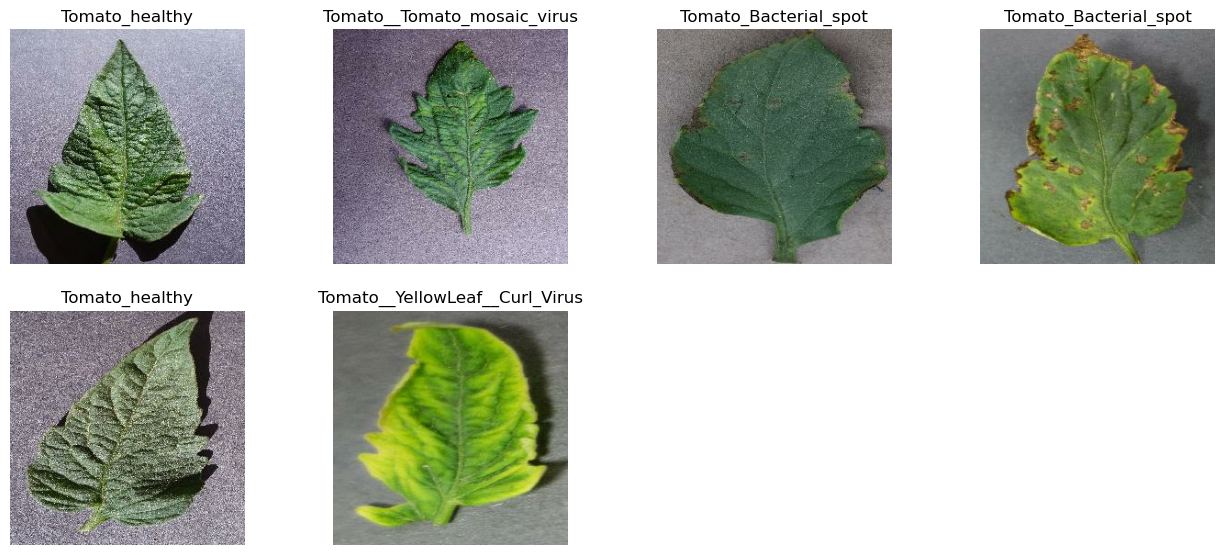

In [100]:
from ensure import ensure_annotations
def plot_sample(index: int):
    plt.figure(figsize=(16,14))   
    for img_batch, label in dataset.take(index):
        for img in range(6):
            ax = plt.subplot(4,4, img+1)
            plt.imshow(img_batch[img].numpy().astype('uint8'))
            plt.title(class_names[label[img]])
            plt.axis("off")
            
plot_sample(6)        

In [101]:
len(dataset)
# 272*32 = 8704

# split into training, validation and test sets

#  training set = 80
#  validation set = 10
#  test set = 10

#  training set
(0.8)*len(dataset)

#  validation set = 10
#(0.10)*len(dataset)

#  test set = 10
#(0.10)*len(dataset)


217.60000000000002

In [102]:
# split into train and test samples

def split_dataset(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(dataset) # find the length of the dataset 
    
    if shuffle:
      dataset = dataset.shuffle(shuffle_size, seed=12) # shuffle
    
    train_size = int(train_split * ds_size) # .8 * 8704
    val_size = int(val_split * ds_size) # .1 * 8704
    
    train_dataset = dataset.take(train_size)  # 217 - in batches  
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [103]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

217
27
28


In [104]:
# shuffle the train_dataset and then cache for easier access with prefecth during training
train_dataset= train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val_dataset= val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_dataset= test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [105]:
# Resize and Scale layer
resize_scale_layer= tf.keras.Sequential([
    tf.keras.layers.Resizing(
    width=image_resize, 
    height=image_resize,
    # interpolation="bilinear",
    # crop_to_aspect_ratio=False,
    # pad_to_aspect_ratio=False,
    # fill_mode="constant",
    # fill_value=0.0,
    # data_format=None,
    ),
    
    tf.keras.layers.Rescaling(1.0/ 255) # normalize the array
])

In [106]:
# data augmentation layer
data_augmentation_layer= tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), # flip and rotate
    tf.keras.layers.RandomRotation(0.2)
])

In [107]:
batch_size = 32
RGB_channels=3

In [108]:
input_shape_=  (batch_size, image_resize, image_resize, RGB_channels)
classes = len(class_names)

model = tf.keras.models.Sequential([
        resize_scale_layer,
        data_augmentation_layer,
        layers.Conv2D(filters= 32,kernel_size= (3,3), activation='relu', input_shape=input_shape_),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64,  kernel_size = (3,3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64, kernel_size= (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64,  kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(filters=64,  kernel_size=(3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(classes, activation='softmax')   
])


model.build(input_shape=input_shape_)

In [109]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [110]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [111]:
history= model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data= val_dataset,
    epochs= 50,
    verbose=1
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.4933 - loss: 1.1989 - val_accuracy: 0.8032 - val_loss: 0.4971
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 39s 182ms/step - accuracy: 0.8253 - loss: 0.4739 - val_accuracy: 0.8843 - val_loss: 0.3466
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.8895 - loss: 0.3134 - val_accuracy: 0.8495 - val_loss: 0.4198
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.9042 - loss: 0.2477 - val_accuracy: 0.9097 - val_loss: 0.2374
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.9361 - loss: 0.1858 - val_accuracy: 0.9421 - val_loss: 0.1602
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 39s 182ms/step - accuracy: 0.9394 - loss: 0.1726 - val_accuracy: 0.9375 - val_loss: 0.1736
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.9496 - loss: 0.1418 - val_accuracy: 0.9016 - val_loss: 0.2670
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 0.9584 - loss: 0

In [112]:
# evaluation
score= model.evaluate(test_dataset)

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9571 - loss: 0.1509


In [113]:
# plot 
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

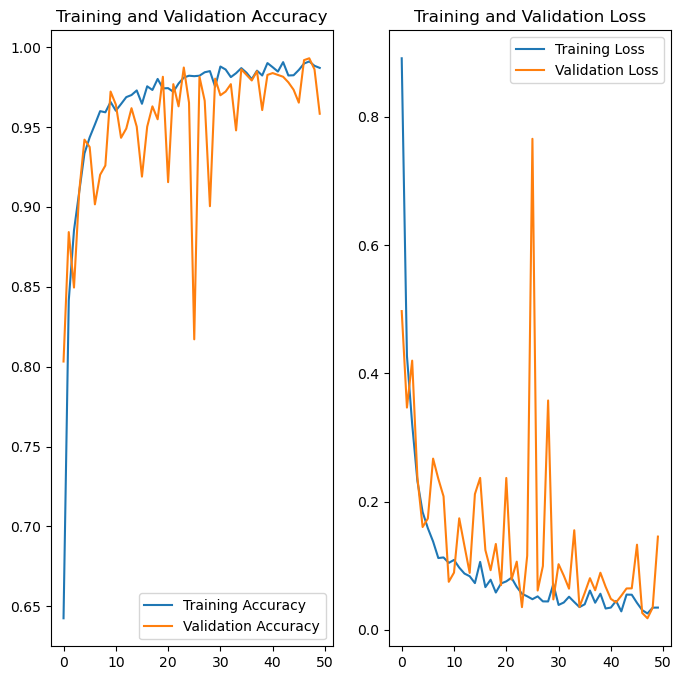

In [115]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(history.params['epochs']), acc, label='Training Accuracy')
plt.plot(range(history.params['epochs']), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(history.params['epochs']), loss, label='Training Loss')
plt.plot(range(history.params['epochs']), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [116]:
#validation loss(error) decreases with time - it is converging

first image to predict
actual label: Tomato__YellowLeaf__Curl_Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
predicted label: Tomato__YellowLeaf__Curl_Virus


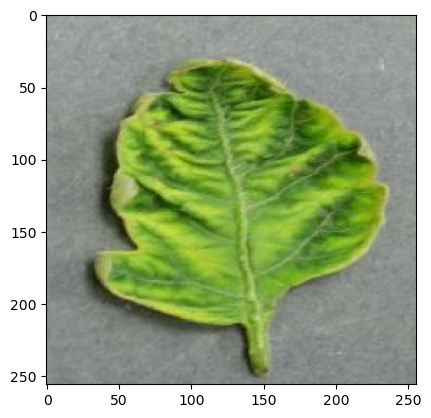

In [117]:

import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [118]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # convert image into a numpy array
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


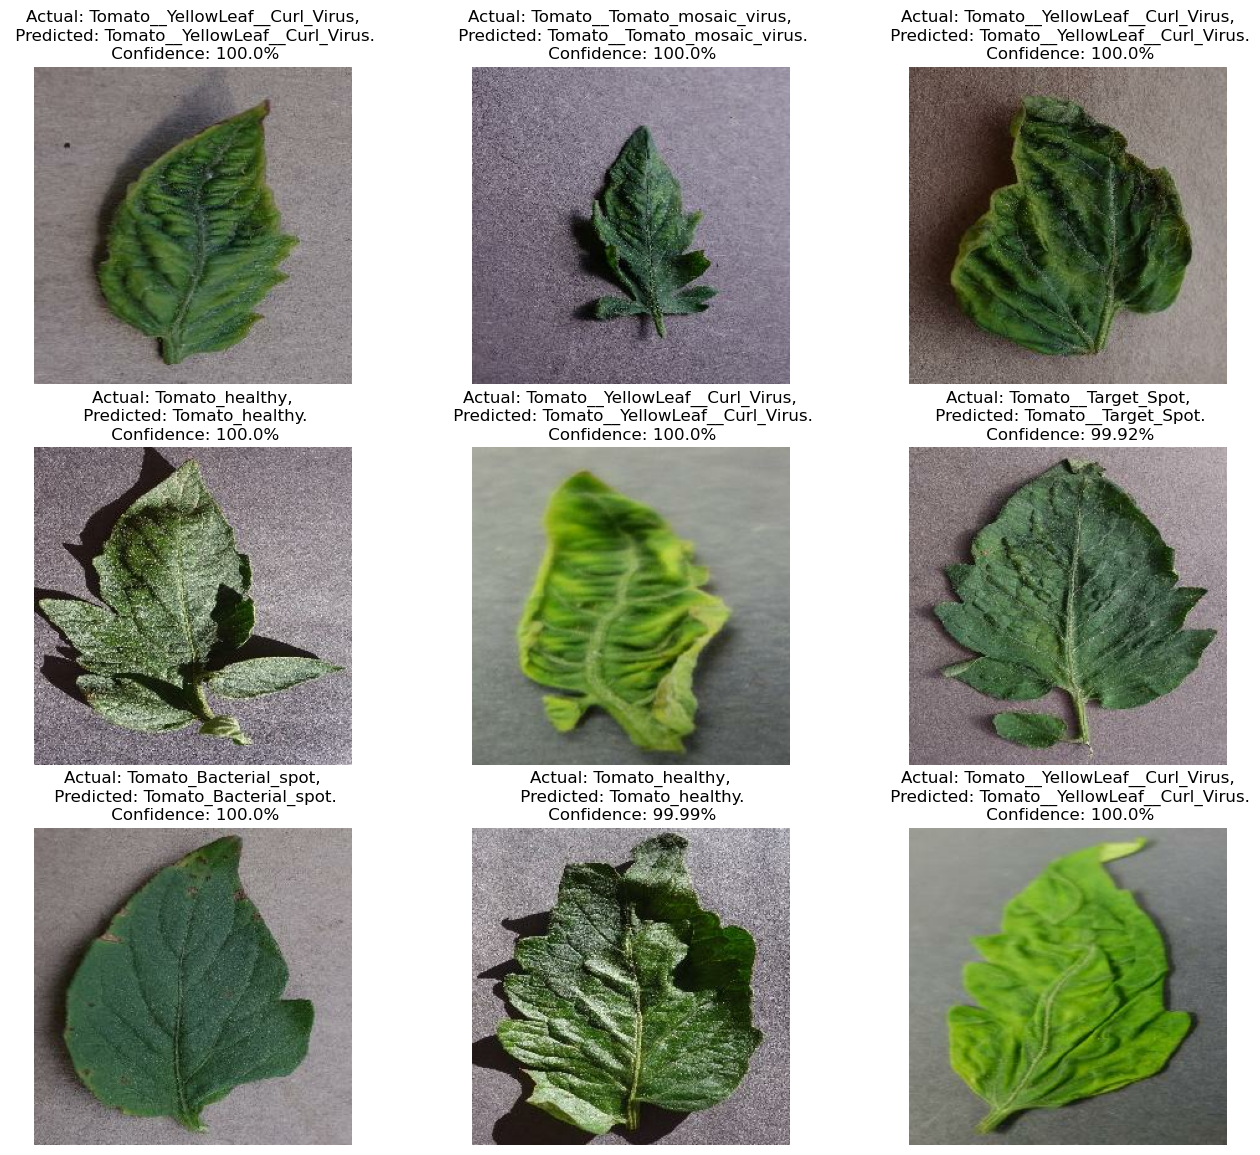

In [119]:
plt.figure(figsize=(16,14))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [123]:
# Save the model 
import os

model_version=1.01 # model version
newpath = f'C:\\Users\\P r x n c E  L i x H\\Documents\\M_L\\projects\\Disease_detection\\saved_models\\{model_version}' #path to save model



if not os.path.exists(newpath): # create path
    os.makedirs(newpath)
    
model.save(f'C:/Users/P r x n c E  L i x H/Documents/M_L/projects/Disease_detection/saved_models/{model_version}/model.keras') # save model
